# 8 Nov 22 - The Inverse Fourier Transform

We used the Fourier Transform to find all the frequency compeonents of a signal.

$$f(t) = \sum_{k=-{\infty}}^{\infty} \gamma_k e^{i2\pi k t/T_0}$$

For a given signal $V(t)$, we can find the unknown complex valued coefficients $\gamma_k$ using the standard integral formulation:

$$\gamma_k = \dfrac{1}{T_0}\int_0^{T_0} V(t) e^{-i2\pi k t/T_0} dt$$

This integral cannot be computed in general, but needs to have the $V(t)$ either as a function or data. In the case of data or a non-integrable function a [Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) ($T_0$ broken into $N$ discrete chunks) is used to compute the integrals (e.g., using Trapezoidal method or Simpson's rule).

$$c_k = \dfrac{1}{N} \sum_{n=0}^{N-1}V(t_n)e^{-i2\pi k n/N}$$

I use $c_k$ to indicate it's the discrete and approximate value of $\gamma_k$. That is we'd hope as $N \rightarrow \infty$ that $c_k \rightarrow \gamma_k$.

We can recover the original signal $V(t)$ from these frequency components using the [Inverse (Discrete) Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Inverse_transform). This transform is written mathematically below:

$$V(t) = \dfrac{1}{N}\sum_{k=0}^{N-1}c_ke^{i 2\pi kn/N}$$

Both of these discrete approaches appear in the `scipy` library: `fft` and `ifft`. It might not seem obvious why we would need these tools. If we have $V(t)$, why would we ever need to transform the signal and transform it back? 

One of the most important aspects of real data is noise. Sometimes we want it, sometimes we need to have it in an experiment, most of the times, we don't! Let's get rid of noise from a constructed spectrum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import scipy.signal as sig
%matplotlib inline

## Cleaning a spectrum

Let's start with a constructed spectrum before we analyze real data. Check out the signal below. This could be thought of a transiting planet eclipsing a local star, a voltage measurement from a defect in a STM sample, really anything. There's lots of signals that look like this!

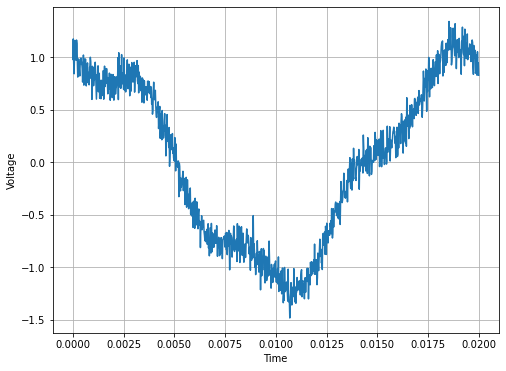

In [2]:
A = 1
B = 0.1
C = -0.2

## Zero centered noise
mu = 0
sigma = 0.1

fA = 50
fB = 80
fC = 200

T0 = 1/fA
N = 1000
dt = T0/N

t = np.linspace(0,T0,N)
Vdusty = A*np.cos(2*np.pi*fA*t)+B*np.sin(2*np.pi*fB*t)+C*np.sin(2*np.pi*fC*t)+np.random.normal(mu,sigma,len(t))

fig = plt.figure(figsize=(8,6))
plt.plot(t,Vdusty)
plt.ylabel('Voltage')
plt.xlabel('Time')
plt.grid()

Let's perform the FFT and look at it.

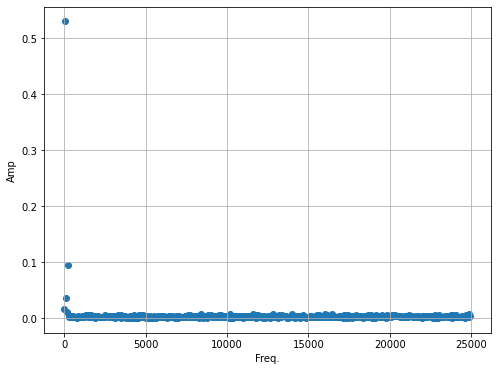

In [3]:
Vdustyf = (1/(N))*fft(Vdusty)
freq = fftfreq(N,dt)

plt.figure(figsize=(8,6))
plt.scatter(freq[0:N//2], np.abs(Vdustyf[0:N//2]))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()

(0.0, 1000.0, 0.0, 1.0)

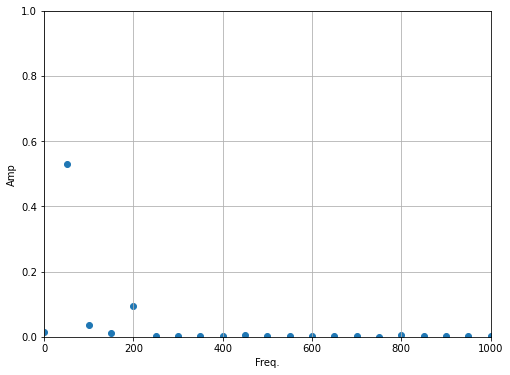

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(freq[0:N//2], np.abs(Vdustyf[0:N//2]))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.axis([0,1000,0,1])

(0.0, 500.0, 0.0, 0.6)

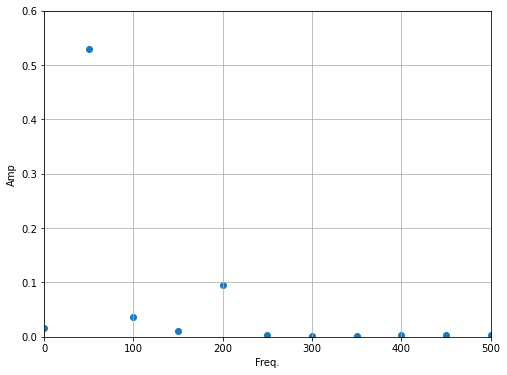

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(freq[0:N//2], np.abs(Vdustyf[0:N//2]))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.axis([0,500,0,0.6])

(500.0, 25000.0, 0.0, 0.02)

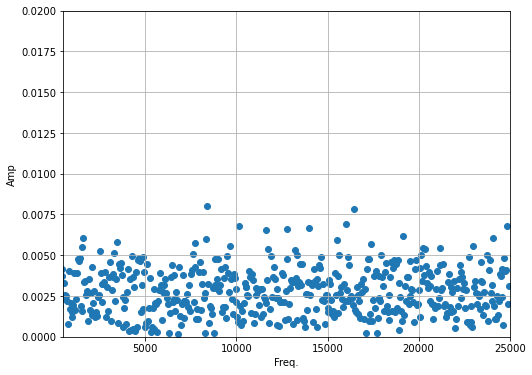

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(freq[0:N//2], np.abs(Vdustyf[0:N//2]))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.axis([500,25000,0,0.02])

Looks like a lot of noise at high frequencies. Let's get rid of it. Remember there's negative frequencies! Those are important to recovering everything.



(-1000.0, 1000.0, 0.0, 1.0)

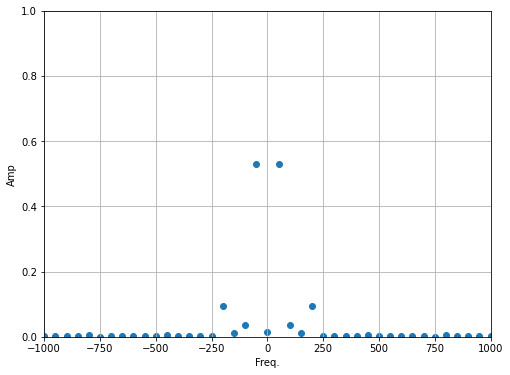

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(freq, np.abs(Vdustyf))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.axis([-1000,1000,0,1])

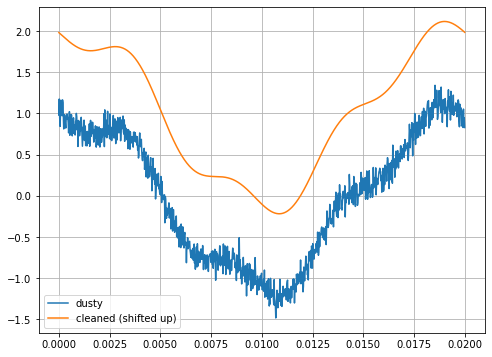

In [8]:
## Kill off anything above 400Hz (just set them to zero)

VCleanf = Vdustyf.copy()

## Your line of code here
VCleanf[freq > 200] = 0
VCleanf[freq < -200] = 0

VClean = ifft(N*VCleanf)

plt.figure(figsize=(8,6))
plt.plot(t,Vdusty, label='dusty')
plt.plot(t,np.real(VClean)+1, label='cleaned (shifted up)')
plt.grid()
plt.legend()

## Investigate Limits and modulations

We have developed a very simple approach (we set all high frequencies to zero). But this is more general!

1. Take FFT of signal $V(t)$
2. Manipulate FFT
3. Take IFFT to get processed signal $V'(t)$

Let's see how many ways we can do this wrong, and what the limits are. Try the following:

1. Replace the IFFT call to use the real values only of the signal, how about only positive frequencies?
2. Add a phase constant to the signal and try to recover the signal again. If you take only real values or positive frequencies what happens to the IFFT? What information are we losing?
3. Modulate the FFT with a function (that is chose to make some other cool transform on the FFT (not just zeroing out)), what happens to the IFFT?
4. What other cool stuff can you do?

## Real data

Let's bring in a audio signal. This will play it. It's a D Power Chord.

In [9]:
!pip install playsound
from playsound import playsound
playsound('data/D_PowerChords_95_SP.wav')

playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


FileNotFoundError: [Errno 2] No such file or directory: '/System/Library/Frameworks/Python.framework/Versions/2.7/bin/python'

Let's read the file into an array and plot it. Notice there are two channels.

In [16]:

from scipy.io import wavfile
samplerate, data = wavfile.read('data/D_PowerChords_95_SP.wav');

print(f"number of channels = {data.shape[1]}")
length = data.shape[0] / samplerate
print(f"length = {length}s")

number of channels = 2
length = 0.8224716553287982s


/var/folders/5_/9z7lhk0s2y95hvkzs6lzdvvc0000gn/T/ipykernel_60208/242547925.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('data/D_PowerChords_95_SP.wav');


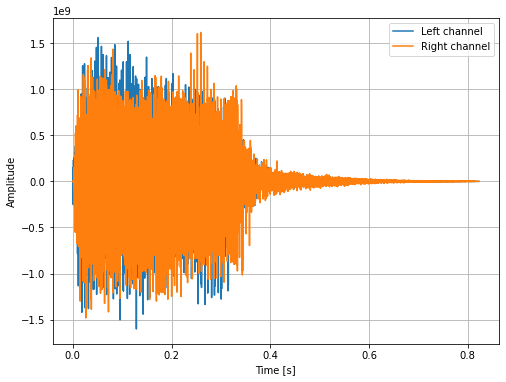

In [17]:
time = np.linspace(0., length, data.shape[0])

fig = plt.figure(figsize=(8,6))
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

## Activity

1. Construct an FFT of this signal
2. Manipulate it in some way
3. Reconstruct the signal
4. (Challenge) Write it out as a wave file and let's hear it!